In [1]:
from promis import ProMis, StaRMap
from promis.geo import PolarLocation, CartesianMap, CartesianLocation, CartesianRasterBand, CartesianCollection
from promis.loaders import OsmLoader
from numpy import eye
import matplotlib.pyplot as plt

from promis.geo.polygon import CartesianPolygon
from promis.geo.route import CartesianRoute
import numpy as np
from pathlib import Path

In [2]:
%reload_ext autoreload
%autoreload 2

In [10]:
# The features we will load from OpenStreetMap
# The dictionary key will be stored as the respective features location_type
# The dictionary value will be used to query the relevant geometry via Overpass
feature_description = {
    "park": "['leisure' = 'park']",
    "primary": "['highway' = 'primary']",
    "secondary": "['highway' = 'secondary']",
    "tertiary": "['highway' = 'tertiary']",
    "service": "['highway' = 'service']",
    "residential": "['highway' = 'residential']",
    "crossing": "['footway' = 'crossing']",
    "living_street": "[highway=living_street]",
    "unclassified": "[highway=unclassified]",
    # "bay": "['natural' = 'bay']",
    "rail": "['railway' = 'rail']",
    # oneway?
    # give way, stop?
    "signal": "['highway' = 'traffic_signals']",
}

# Covariance matrices for some of the features
# Used to draw random translations representing uncertainty for the respective features
covariance = {
    "secondary": 10 * eye(2),
    "residential":5 * eye(2),
    # cov of traffic_signal?
}

# The probabilistic, logical constraints to fulfill during a mission
logic = """
    on_road(X) :-
        distance(X, primary) < 5, distance(X, primary) > 1;
        distance(X, secondary) < 4;
        distance(X, tertiary) < 2;
        distance(X, living_street) < 2.5;
        distance(X, residential) < 2.5;
        distance(X, unclassified) < 2;
        distance(X, service) < 2.

    % Permits related to local features
    permits(X) :- 
        on_road(X),
        distance(X, signal) > 4,
        distance(X, crossing) > 2.

    % Definition of a valid mission
    landscape(X) :-  
        on_road(X).
"""

- Ursprünglich mit over modelliert.
- Klappt nicht für flächenlose Strukturen wie Straßen, da die als Line Strings codiert sind
- Nutzung der distance Relation ist ein easy fix hier, aber nicht überall valide
    - zB in Sackgassen (Straße geht noch width weiter)
    - alle Straßen haben gleiche width
- möglicher Fix: Rasterisierung von Straßen als Polygone? feinere Auflösung, mehr trennbar in Spuren

In [11]:
origin = PolarLocation(latitude=49.876882, longitude=8.650317)
width, height = 80.0, 80.0
number_of_random_maps = 25
support = CartesianRasterBand(origin, (80, 80), width, height)  # This is the set of points that will be directly computed through sampling (expensive)
target = CartesianRasterBand(origin, (250, 250), width, height)  # This is the set of points that will be interpolated from the support set (cheap)
# alternative = CartesianCollection(origin, [CartesianLocation(42, 42)])  # Alternatively, arbitrary points can be set for either set

# Setting up the Uncertainty Annotated Map from OpenStreetMap data
if not Path(f"data/uam_close.pkl").exists():
    uam = OsmLoader(origin, (width, height), feature_description).to_cartesian_map()
    #uam.features.append(CartesianLocation(0.0, 0.0, location_type="operator"))  # We can manually add additional features
    uam.apply_covariance(covariance)  # Assigns the covariance matrices defined earlier
    uam.save(f"data/uam_close.pkl")  # We can save and load these objects to avoid recomputation 

In [12]:
star_map = StaRMap(target, CartesianMap.load(f"data/uam_close.pkl"))
star_map.initialize(support, number_of_random_maps, logic)  # This estimates all spatial relations that are relevant to the given logic
star_map.save(f"data/star_map_close.pkl")

# Solve the mission area with ProMis
promis = ProMis(StaRMap.load(f"data/star_map_close.pkl"))
landscape = promis.solve(support, logic, n_jobs=4, batch_size=1)
landscape.save(f"data/landscape_close.pkl")

/home/julius/Documents/ba_inf_6/bachelorarbeit/ProMis/.venv/lib/python3.10/site-packages/promis/star_map.py:478: UserWarning: no features for relation "distance" for location type "unclassified"
  warn(
/home/julius/Documents/ba_inf_6/bachelorarbeit/ProMis/.venv/lib/python3.10/site-packages/promis/star_map.py:478: UserWarning: no features for relation "distance" for location type "living_street"
  warn(
/home/julius/Documents/ba_inf_6/bachelorarbeit/ProMis/.venv/lib/python3.10/site-packages/promis/star_map.py:478: UserWarning: no features for relation "distance" for location type "tertiary"
  warn(
/home/julius/Documents/ba_inf_6/bachelorarbeit/ProMis/.venv/lib/python3.10/site-packages/promis/star_map.py:478: UserWarning: no features for relation "distance" for location type "signal"
  warn(
/home/julius/Documents/ba_inf_6/bachelorarbeit/ProMis/.venv/lib/python3.10/site-packages/promis/star_map.py:478: UserWarning: no features for relation "distance" for location type "primary"
  warn(

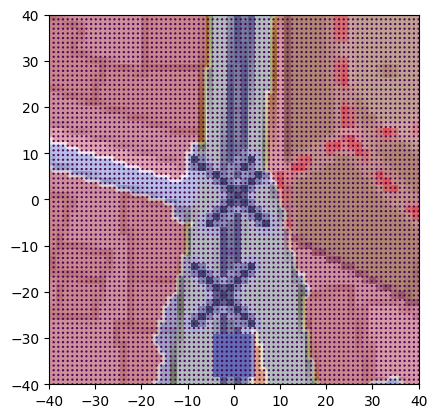

In [13]:
ax = plt.subplot()
landscape = CartesianCollection.load("data/landscape_close.pkl")
landscape.scatter(s=0.4, plot_basemap=True, rasterized=True, cmap="coolwarm_r", alpha=0.2, ax=ax)
support.scatter(s=0.4, ax=ax, plot_basemap=False)
plt.show()